In [2110]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2111]:
import numpy as np
import matplotlib.pyplot as plt


from neuron_population import NeuronPopulation
from connectome import Connectome
from overhead import Simulation

In [2112]:
dt = 0.1

In [2113]:
# Neuron population parameters
layer_distribution = [2, 20, 2]
n_layers = 3
neuron_types = ["TRN", "p23", "nb"]
n_neuron_types = len(neuron_types)
inhibitory = [False, False, True]
dist_layer1 = np.array([1, 0, 0])
dist_layer2 = np.array([0, 8, 2])
dist_layer3 = np.array([1, 0, 0])
neuron_distribution = [dist_layer1, dist_layer2, dist_layer3]
threshold_decay = np.exp(-dt / 5)
layer_distances = np.zeros((n_layers, n_layers))
# mm
layer_distances[0, 0] = 0.6
layer_distances[1, 1] = 0.6
layer_distances[2, 2] = 0.6
layer_distances[0, 1] = 5.0
layer_distances[1, 0] = 5.0
layer_distances[1, 2] = 5.0
layer_distances[2, 1] = 5.0
layer_distances[0, 2] = 10.0
layer_distances[2, 0] = 10.0

In [2114]:
neuron_pop = NeuronPopulation(
    layer_distribution,
    neuron_distribution,
    layer_distances,
    neuron_types,
    inhibitory,
    threshold_decay,
    threshold_mult=1.15
)

In [2115]:
# Connectome
max_synapses = 18
synapse_strength = np.ones((n_layers, n_layers))
# neuron_types = ["p23", "TRN", "b", "nb"]
connectivity_probability = np.ones((n_layers, n_layers, n_neuron_types, n_neuron_types+2))


connectivity_probability[:,:,:,-2] = 0.0  # Self connections
connectivity_probability[:,:,:,-1] = 0.0  # No empty connections
# No inter-connections for input and output layers
connectivity_probability[0, 0, :, :-2] = 0
connectivity_probability[2, 2, :, :-2] = 0
# Only flow in one direction
connectivity_probability[1, 0, :, :-2] = 0.0
connectivity_probability[2, 1, :, :-2] = 0.0
connectivity_probability[2, 0, :, :-2] = 0.0
# No jump from input to output
connectivity_probability[0, 2, :, :-2] = 0.0

In [2116]:
connectome = Connectome(
    max_synapses,
    neuron_pop,
    connectivity_probability,
    synapse_strength,
)

In [2117]:
# connectome.M

In [2118]:
# connectome.distances

In [2119]:
sim = Simulation(connectome, dt, stepper_type="adapt")

In [2120]:
weights_t0 = connectome.W.copy()

In [2121]:
# connectome.W.copy()

In [2122]:
I_ext = np.zeros((neuron_pop.n_neurons))
I_ext[0] = 100
I_ext[-2] = 100

# I_ext = 100

for i in range(10000):
    sim.step(I_ext=I_ext)
    # print(sim.synapse_dynamics.g_ST)
    # if np.sum(sim.pre_spikes) > 0:
        # print(f"Step {i}, {sim.t_now}, heap size: {(sim.axonal_dynamics._heap)}")
        # print(sim.pre_spikes)

weights_t1 = connectome.W.copy()

In [2123]:
# sim.synapse_dynamics.g_GABA_B

In [2124]:
neuron_pop.inhibitory_mask

array([False, False, False,  True,  True, False,  True, False, False,
        True,  True, False,  True, False, False,  True, False, False,
       False, False,  True, False, False, False])

In [2125]:
sim.neuron_states.V

array([-62.91249251, -60.        , -60.68675711, -71.54528947,
       -32.64891603, -61.97674186, -70.16865521, -67.15074068,
       -59.68873247, -55.75772994, -55.0815927 , -60.93971285,
       -67.18099795, -69.05887127, -61.24591265, -60.79927795,
       -67.05968444, -60.13730837, -59.37526902, -62.41304275,
       -53.51429026, -60.61021687, -76.7251218 , -79.87954405])

In [2126]:
# weights_t1 # [neuron_pop.inhibitory_mask]

In [2127]:
# weights_t1 -   weights_t0

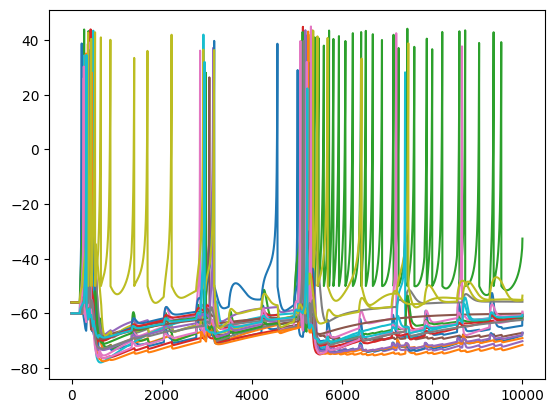

In [2131]:
plt.plot(np.array(sim.stats.Vs)[:, neuron_pop.get_neurons_from_layer(1)])
plt.show()

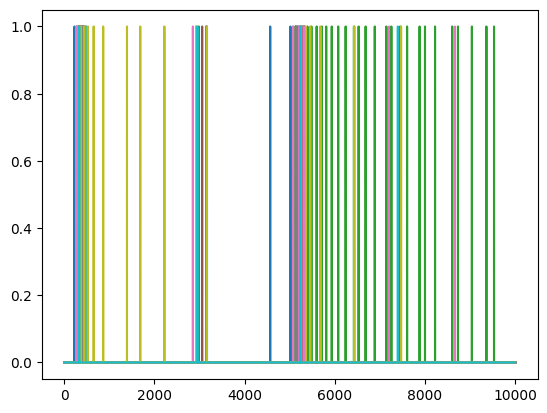

In [2129]:
plt.plot(np.array(sim.stats.spikes)[:, neuron_pop.get_neurons_from_layer(1)])
plt.show()